In [4]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(glue))
suppressMessages(library(ggpointdensity))
suppressMessages(library(magrittr))

In [5]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=180)

In [6]:
suppressMessages(library(cowplot))
theme_set(theme_cowplot(font_size = 14))

In [10]:
setwd("~/cdai/SpliFi/analysis")

In [18]:
getwd()

[1] "/project2/yangili1/cdai/SpliFi/analysis"

# Intro - Plot heatmap of unproductive splicing introns across GTEx tissues

heatmap data:
  - rows: top unproductive introns
  - columns: GTEx tissues
  - values: PSI values

howto:
  - pick top unproductive introns: 
    1. get top deltaPSI unprod introns from a set of contrasts
    2. union these introns
  - get PSI values for these introns across GTEx tissues


# Preprocessing data to save a little time

# Load input data - starting point

In [12]:
data <- readRDS("../data/ds_v_dge/all_contrast_data.rds")

[1] 702

# Functions

In [55]:
data[[2]]$ds[1:5]


intron,cluster,itype,ctype,gene_name,gene_id,logef,Artery-Coronary,Adipose-Visceral_Omentum_,deltapsi,status,loglr,df,p,p.adjust
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
chr1:924948:925921:clu_10_+,chr1:clu_10_+,PR,PR,SAMD11,ENSG00000187634.11,-0.1296342,0.84889535,0.820527996,-0.028367353,Success,3.147330,2,0.0429667,0.1212188
chr1:925189:925921:clu_10_+,chr1:clu_10_+,PR,PR,SAMD11,ENSG00000187634.11,0.5404112,0.05970018,0.112774754,0.053074578,Success,3.147330,2,0.0429667,0.1212188
chr1:925800:925921:clu_10_+,chr1:clu_10_+,PR,PR,SAMD11,ENSG00000187634.11,-0.4107770,0.09140448,0.066697250,-0.024707226,Success,3.147330,2,0.0429667,0.1212188
chr1:930336:931038:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,-0.2562305,0.54092240,0.498521254,-0.042401147,Success,2.091575,2,0.1234924,0.2635774
chr1:930336:935771:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,0.3453669,0.00243098,0.004088844,0.001657864,Success,2.091575,2,0.1234924,0.2635774


In [60]:
# functions used later
GetHeatmapMatrix <- function(dt, clusters, contrast) {
  # dt$intron2 <- str_replace_all(dt$intron, ":clu_\\d+_", "")
  tissues <- str_split(contrast, "_v_") %>% unlist()
  keep1 <- c("intron", "cluster", tissues[1], "itype", "ctype")
  keep2 <- c("intron", "cluster", tissues[2], "itype", "ctype")
  out <- list(
    dt[cluster %in% clusters, keep1, with = FALSE],
    dt[cluster %in% clusters, keep2, with = FALSE]
  )
  names(out) <- tissues

  return(out)
}


In [14]:
GetTopUpIntrons <- function(data, FDR_ds, FDR_dge, dPSI) {
  dge <- data$dge
  ds <- data$ds

  # if a cluster has multiple UP introns, only select the best 1
  ds <- ds[itype == 'UP' & ctype == 'PR,UP'][, rk := rank(-abs(deltapsi), ties.method = "first"), by = cluster][rk ==1][, rk := NULL][]
  ds <- ds[`p.adjust` < FDR_ds & abs(deltapsi) > dPSI,]

  dge <- dge[padj < FDR_dge,]
  
  ds_excl_cols <- c('itype', 'ctype', 'df', 'p', 'p.adjust','logef', 'loglr', 'status')
  dge_excl_cols <- c('baseMean', 'lfcSE', 'stat', 'pvalue', 'padj')
  chosen <- inner_join(
      x = ds[, -ds_excl_cols, with = FALSE],
      y = dge[, -dge_excl_cols, with = FALSE],
      by = "gene_id",
      suffix = c("_ds", "_dge")
    ) %>%
    .[deltapsi * log2FoldChange < 0, ]

  return(chosen)
}
  

# Confirm that across all DS results, cluster IDs are the same

Yes! I randomly selected 500 tissue pairs. Between any given 2 sets of tissue pairs, about 80-85% of introns are detected in both sets. And the cluster IDs are exactly the same. 

**So it's confirmed that all cluster IDs are the same in all differential splicing leafcutter results.**


# Select a union set of unproductive intron clusters

Choose introns based on the following criteria:
1. ds FDR
2. deltaPSI
3. dge FDR
4. select the best unprod. intron from each cluster, then collect cluster ID

In [15]:
# select unproductive introns with these criteria for ds and dge analyses
FDR = c(ds = 1e-3, dge = .05)
dPSI = .1

In [42]:
chosen_clusters <- readRDS("../data/ds_v_dge/chosen_clusters.rds")


In [43]:
chosen_clusters %>% str()


 chr [1:5482] "chr1:clu_73_+" "chr1:clu_317_+" "chr1:clu_733_+" ...


In [46]:
data[[1]]$ds[1:5, ]


intron,cluster,itype,ctype,gene_name,gene_id,logef,AdrenalGland,Adipose-Visceral_Omentum_,deltapsi,status,loglr,df,p,p.adjust
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>
chr1:924948:925921:clu_10_+,chr1:clu_10_+,PR,PR,SAMD11,ENSG00000187634.11,-0.12110002,0.85148976,0.82463705,-0.02685272,Success,2.656666,2,0.07018180,0.12336424
chr1:925189:925921:clu_10_+,chr1:clu_10_+,PR,PR,SAMD11,ENSG00000187634.11,0.48542135,0.06155265,0.10932992,0.04777727,Success,2.656666,2,0.07018180,0.12336424
chr1:925800:925921:clu_10_+,chr1:clu_10_+,PR,PR,SAMD11,ENSG00000187634.11,-0.36432132,0.08695759,0.06603303,-0.02092456,Success,2.656666,2,0.07018180,0.12336424
chr1:930336:931038:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,-0.07830811,0.53982645,0.50075694,-0.03906951,Success,2.087558,1,0.04102174,0.07796329
chr1:931089:935771:clu_11_+,chr1:clu_11_+,PR,PR,SAMD11,ENSG00000187634.11,0.07830811,0.46017355,0.49924306,0.03906951,Success,2.087558,1,0.04102174,0.07796329


In [48]:
plot_clusters <- map(data, ~ .x$ds[, cluster]) %>% # get clusters for each pair
  map(., ~ intersect(.x, chosen_clusters)) %>% # intersect with chosen clusters
  reduce(intersect) # chosen clusters that are common across all tissue pairs


In [214]:
str(plot_clusters)


 chr [1:2279] "chr1:clu_14_+" "chr1:clu_15_+" "chr1:clu_32_+" ...


In [ ]:
# all plot_clusters should exist in each tissue

In [61]:
GetHeatmapMatrix


function(dt, clusters, contrast) {
  # dt$intron2 <- str_replace_all(dt$intron, ":clu_\\d+_", "")
  tissues <- str_split(contrast, "_v_") %>% unlist()
  keep1 <- c("intron", "cluster", tissues[1], "itype", "ctype")
  keep2 <- c("intron", "cluster", tissues[2], "itype", "ctype")
  out <- list(
    dt[cluster %in% clusters, keep1, with = FALSE],
    dt[cluster %in% clusters, keep2, with = FALSE]
  )
  names(out) <- tissues

  return(out)
}

In [54]:
names(data[1:5])


[1] "Adipose-Visceral_Omentum__v_AdrenalGland"                       
[2] "Adipose-Visceral_Omentum__v_Artery-Coronary"                    
[3] "Adipose-Visceral_Omentum__v_Brain-Amygdala"                     
[4] "Adipose-Visceral_Omentum__v_Brain-Anteriorcingulatecortex_BA24_"
[5] "Adipose-Visceral_Omentum__v_Brain-Caudate_basalganglia_"

In [215]:
plotdata <- imap(data, ~ GetHeatmapMatrix(.x$ds, plot_clusters, .y)) %>% unlist(recursive = FALSE)


In [221]:
# get the names of stored plot datatable without duplicating dataste
plotdata.names <- names(plotdata) %>%
  str_split("\\.", simplify = T) %>%
  as.data.table() %>%
  .[, .(V1, V2, rk = rank(V1)), by = V2] %>% # after split, V1=contrast, V2=tissue
  .[rk == 1] %>% # since a tissue can be used in multiple contrasts, only keep 1
  .[, .(V1, nm = paste(V1, ".", V2, sep = ""))] %>%
  .[, nm]


In [222]:
str(plotdata.names)


 chr [1:40] "Adipose-Visceral_Omentum__v_AdrenalGland.Adipose-Visceral_Omentum_" ...


In [258]:
# reduce dataset to only the selected tissues
plotdata <- plotdata[plotdata.names]

names(plotdata) <- str_split(names(plotdata), "\\.") %>% map_chr(~.[2])


In [260]:
map(plotdata, ~.x[, cluster]) %>% reduce(intersect) %>% length

[1] 2279

In [226]:
sumPSI <- function(dt, cn) {
  dt <- rename(dt, psi = {{ cn }})
  dt <- dt[itype == "UP"][, .(psi = sum(psi)), by = cluster] # sum unprod PSI by cluster
  names(dt) <- c("cluster", cn)
  return(as.data.table(dt))
}


In [261]:
map(plotdata[1], head)

,intron,cluster,Adipose-Visceral_Omentum_,itype,ctype
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,chr1:962917:963031:clu_14_+,chr1:clu_14_+,0.3310657,UP,"PR,UP"
2,chr1:962917:963108:clu_14_+,chr1:clu_14_+,0.6689343,PR,"PR,UP"
3,chr1:964167:964348:clu_15_+,chr1:clu_15_+,0.5880904,UP,"PR,UP"
4,chr1:964180:964348:clu_15_+,chr1:clu_15_+,0.4119096,PR,"PR,UP"
5,chr1:1325102:1326835:clu_32_+,chr1:clu_32_+,0.4323239,PR,"PR,UP"
6,chr1:1325102:1327240:clu_32_+,chr1:clu_32_+,0.1009685,UP,"PR,UP"


In [263]:
plotdata <- imap(plotdata, ~sumPSI(.x, .y))

In [271]:
plot_clusters %>% length
plot_clusters %>% uniqueN

[1] 2279

[1] 2279

In [275]:
mx_clusters <- intersect(reduce(map(plotdata, ~.x[, cluster]), intersect), plot_clusters)

In [276]:
str(mx_clusters)

 chr [1:2211] "chr1:clu_14_+" "chr1:clu_15_+" "chr1:clu_32_+" ...


In [282]:
plotdata <- map(plotdata, ~.x[cluster %in% mx_clusters])

In [283]:
plotdata[[1]][1:3,]

cluster,Adipose-Visceral_Omentum_
<chr>,<dbl>
chr1:clu_14_+,0.3310657
chr1:clu_15_+,0.5880904
chr1:clu_32_+,0.1009685


In [313]:
# test that all datatable in plotdata has the same order and number of rows, print 1 for passing test
s = 0
N = 50
for (i in 1:N) {
  same = all(plotdata[[sample(1:40,1)]][, cluster] == plotdata[[sample(1:40,1)]][, cluster])
  s = s + same
}
print(s/N)

[1] 1


In [314]:
# 
mx <- cbind(plotdata[[1]][,1], map_dfc(plotdata, ~.x[,2]))

In [286]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(viridis))

In [315]:
mx %>% dim
mx %>% head
mx[, cluster] %>% uniqueN

[1] 2211   41

cluster,Adipose-Visceral_Omentum_,AdrenalGland,Artery-Coronary,Brain-Amygdala,Brain-Anteriorcingulatecortex_BA24_,Brain-Caudate_basalganglia_,Brain-CerebellarHemisphere,Brain-Cerebellum,Brain-Cortex,⋯,Prostate,Skin-NotSunExposed_Suprapubic_,SmallIntestine-TerminalIleum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,WholeBlood
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:clu_14_+,0.33106572,0.27075988,0.27967047,0.19513756,0.16583956,0.15217518,0.27378676,0.26682506,0.19480498,⋯,0.31630524,0.37302230,0.35287736,0.37477736,0.34111179,0.24179713,0.30818547,0.25088298,0.35232844,0.42029574
chr1:clu_15_+,0.58809036,0.53012254,0.53813192,0.49981513,0.44951043,0.45793120,0.51700040,0.52315034,0.44983741,⋯,0.55516462,0.58247493,0.62280322,0.61130708,0.57594828,0.40937907,0.56530111,0.55343992,0.56801729,0.61414053
chr1:clu_32_+,0.10096850,0.04895554,0.12436724,0.12509385,0.12879204,0.13071906,0.06977366,0.07383586,0.09434729,⋯,0.07326598,0.05101692,0.04673693,0.06378328,0.05545127,0.01974868,0.07906004,0.08090701,0.06728778,0.11253528
chr1:clu_37_+,0.11080290,0.10410239,0.18813380,0.11709932,0.14459970,0.14506303,0.17194670,0.16983067,0.13508044,⋯,0.13331167,0.15280053,0.14641385,0.10343292,0.14315861,0.09778246,0.13354138,0.23962029,0.14942117,0.05584381
chr1:clu_42_+,0.09715702,0.12041206,0.07698078,0.07365487,0.05276211,0.05468863,0.04504442,0.03958059,0.05003663,⋯,0.08009373,0.01712559,0.03825664,0.03548331,0.05616046,0.29423115,0.04693202,0.02557891,0.02465001,0.02180753
chr1:clu_43_+,0.09177940,0.11286178,0.07758083,0.19069628,0.17005582,0.14323184,0.13638207,0.13089098,0.12968644,⋯,0.09102641,0.09692145,0.09189647,0.09741135,0.08345764,0.08392886,0.10718989,0.08329416,0.09092148,0.08702131


[1] 2211

In [316]:
colnames(mx) <- str_replace_all(colnames(mx), "[_\\-]", "")

In [317]:
colLabels = c(
    AdiposeVisceralOmentum = "Adipose-VisceralOmentum", 
    AdrenalGland = "AdrenalGland", 
    ArteryCoronary = "Artery-Coronary", 
    BrainAmygdala = "Brain-Amygdala", 
    BrainAnteriorcingulatecortexBA24 = "Brain-AnteriorcingulatecortexBA24", 
    BrainCaudatebasalganglia = "Brain-Caudatebasalganglia", 
    BrainCerebellarHemisphere = "Brain-CerebellarHemisphere", 
    BrainCerebellum = "Brain-Cerebellum", 
    BrainCortex = "Brain-Cortex", 
    BrainFrontalCortexBA9 = "Brain-FrontalCortexBA9", 
    BrainHippocampus = "Brain-Hippocampus", 
    BrainHypothalamus = "Brain-Hypothalamus", 
    BrainNucleusaccumbensbasalganglia = "Brain-Nucleusaccumbensbasalganglia", 
    BrainPutamenbasalganglia = "Brain-Putamenbasalganglia", 
    BrainSpinalcordcervicalc1 = "Brain-Spinalcordcervicalc1", 
    BrainSubstantianigra = "Brain-Substantianigra", 
    BreastMammaryTissue = "Breast-MammaryTissue", 
    CellsCulturedfibroblasts = "Cells-Culturedfibroblasts", 
    CellsEBVtransformedlymphocytes = "Cells-EBVtransformedlymphocytes", 
    ColonTransverse = "Colon-Transverse", 
    EsophagusMucosa = "EsophagusMucosa", 
    HeartLeftVentricle = "Heart-LeftVentricle", 
    KidneyCortex = "Kidney-Cortex", 
    Liver = "Liver", 
    Lung = "Lung", 
    MinorSalivaryGland = "MinorSalivaryGland", 
    MuscleSkeletal = "Muscle-Skeletal", 
    Ovary = "Ovary", 
    Pancreas = "Pancreas", 
    Pituitary = "Pituitary", 
    Prostate = "Prostate", 
    SkinNotSunExposedSuprapubic = "Skin-NotSunExposedSuprapubic", 
    SmallIntestineTerminalIleum = "SmallIntestine-TerminalIleum", 
    Spleen = "Spleen", 
    Stomach = "Stomach", 
    Testis = "Testis", 
    Thyroid = "Thyroid", 
    Uterus = "Uterus", 
    Vagina = "Vagina", 
    WholeBlood = "WholeBlood"
)


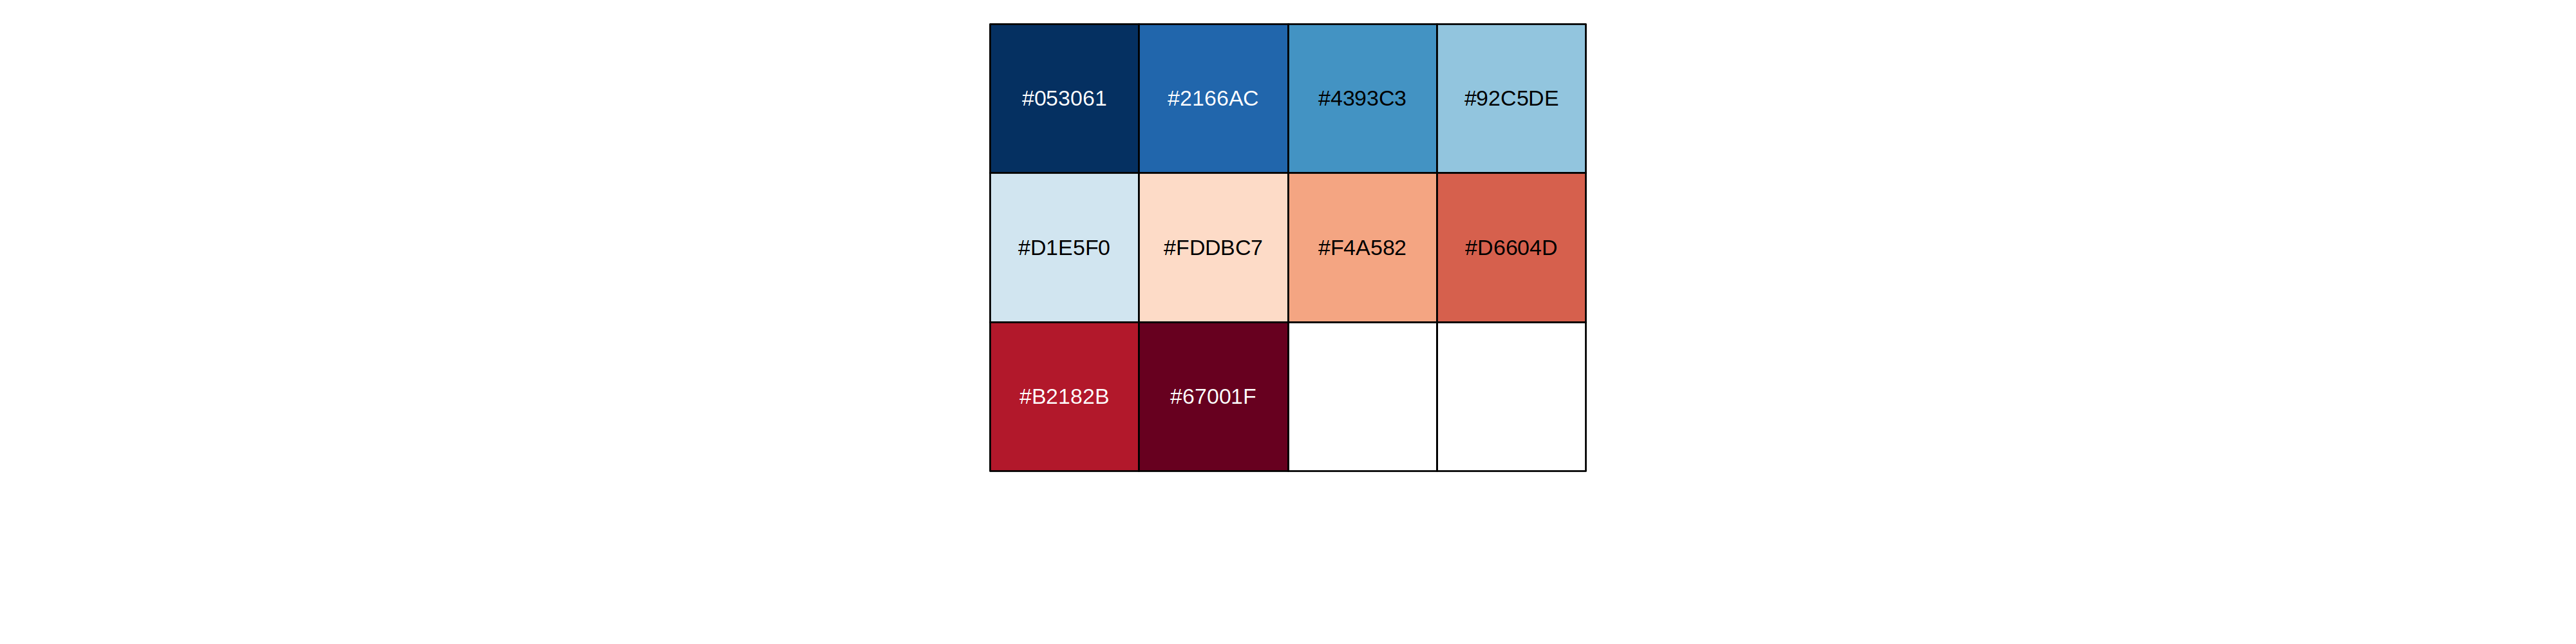

In [344]:
options(repr.plot.width=20, repr.plot.height=5, repr.plot.res = 200)

# display colors
scales::show_col(rev(RColorBrewer::brewer.pal(10, "RdBu")))
scales::show_col(c("#053061", "#2166AC", "#F7F7F7", "#B2182B", "#67001F"))

In [346]:

legendBreaks <- seq(-4, 4, 2)
# colors <- rev(RColorBrewer::brewer.pal(length(legendBreaks), "RdBu"))
colors <- c("#053061", "#2166AC", "#F7F7F7", "#B2182B", "#67001F")
colfunc <- circlize::colorRamp2(
  breaks = legendBreaks, 
  colors = colors
  )


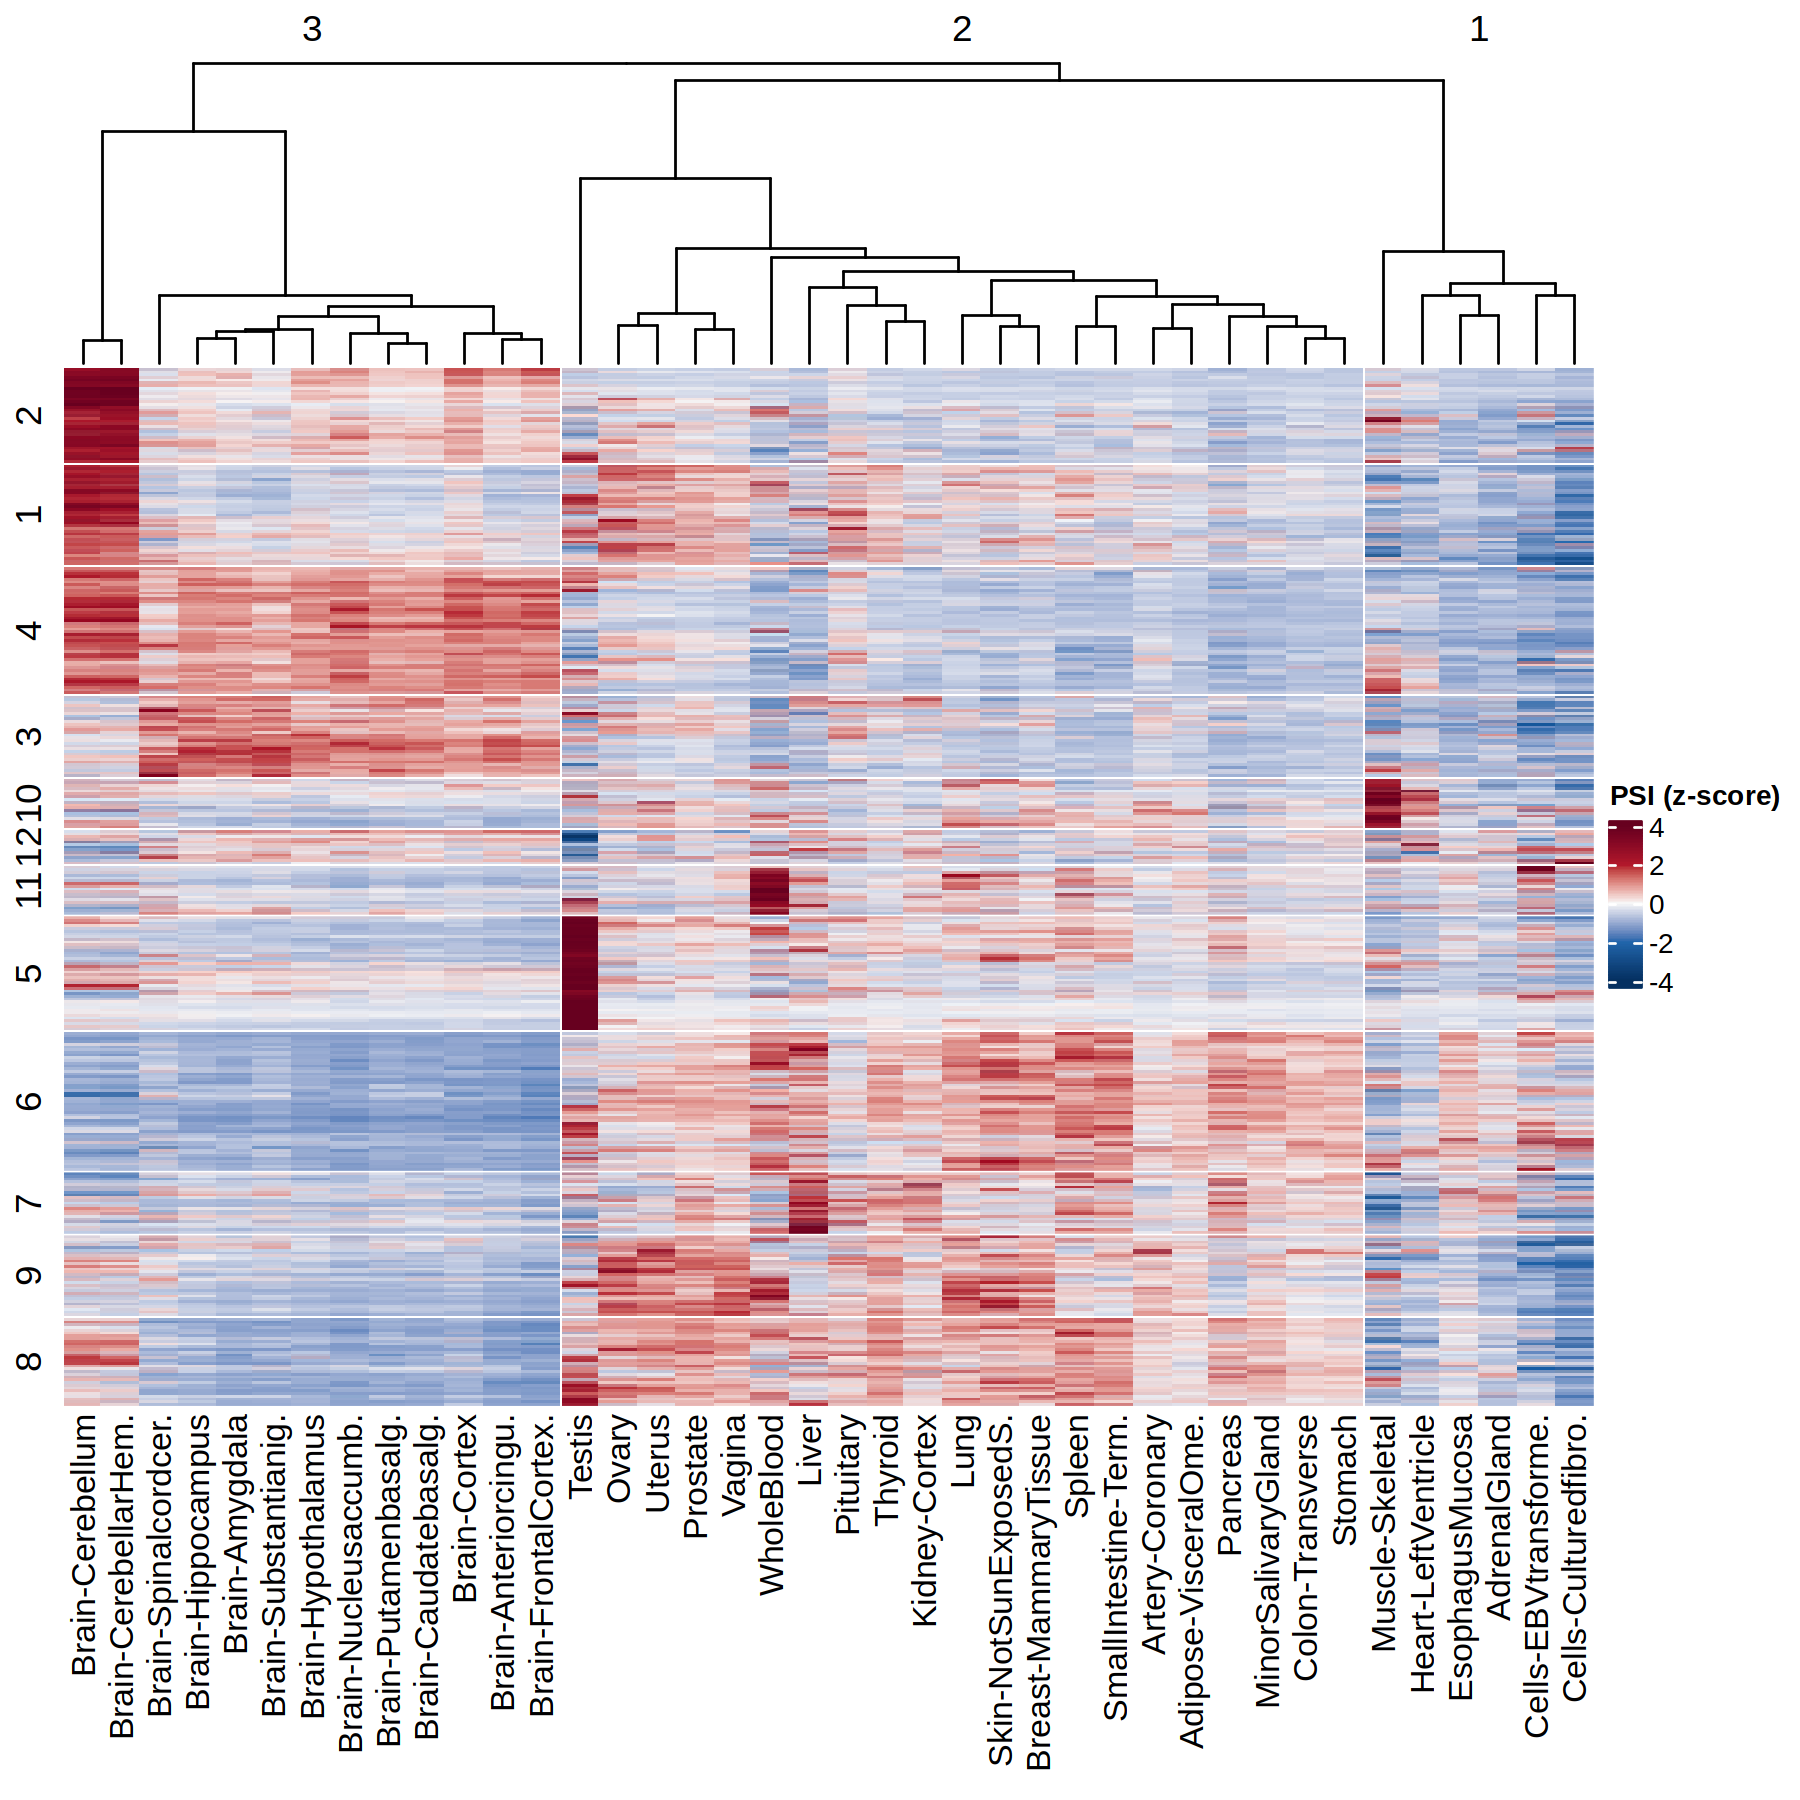

In [349]:
options(repr.plot.width=9, repr.plot.height=9, repr.plot.res = 200)


set.seed(123)
cluster_method <- "ward.D"
ht <- mx %>%
  column_to_rownames("cluster") %>%
  as.matrix %>% t %>% scale %>% t %>%
  Heatmap(
    col = colfunc,
    row_km = 12, row_gap = unit(0.2, "mm"), 
    column_km = 3, column_gap = unit(0.2, "mm"),
    show_parent_dend_line = F,
    show_row_names = FALSE, clustering_method_rows = cluster_method, show_row_dend = F,
    clustering_method_columns = cluster_method, column_dend_height = unit(1.5, "in"), show_column_dend = T,
    column_labels = str_trunc(colLabels, 20, ellipsis = '.'),
    heatmap_legend_param = list(title = "PSI (z-score)"),
    use_raster = T
    )
ht

In [350]:
str(ht)

Formal class 'Heatmap' [package "ComplexHeatmap"] with 31 slots
  ..@ name                   : chr "matrix_11"
  ..@ matrix                 : num [1:2211, 1:40] 0.547 0.885 0.472 -0.559 0.662 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2211] "chr1:clu_14_+" "chr1:clu_15_+" "chr1:clu_32_+" "chr1:clu_37_+" ...
  .. .. ..$ : chr [1:40] "AdiposeVisceralOmentum" "AdrenalGland" "ArteryCoronary" "BrainAmygdala" ...
  .. ..- attr(*, "scaled:center")= Named num [1:2211] 0.2866 0.5311 0.0838 0.1315 0.0631 ...
  .. .. ..- attr(*, "names")= chr [1:2211] "chr1:clu_14_+" "chr1:clu_15_+" "chr1:clu_32_+" "chr1:clu_37_+" ...
  .. ..- attr(*, "scaled:scale")= Named num [1:2211] 0.0812 0.0644 0.0363 0.0369 0.0514 ...
  .. .. ..- attr(*, "names")= chr [1:2211] "chr1:clu_14_+" "chr1:clu_15_+" "chr1:clu_32_+" "chr1:clu_37_+" ...
  ..@ matrix_param           :List of 12
  .. ..$ row_km           : num 12
  .. ..$ row_km_repeats   : num 1
  .. ..$ row_gap          : 'simpleUnit' num 0.2mm


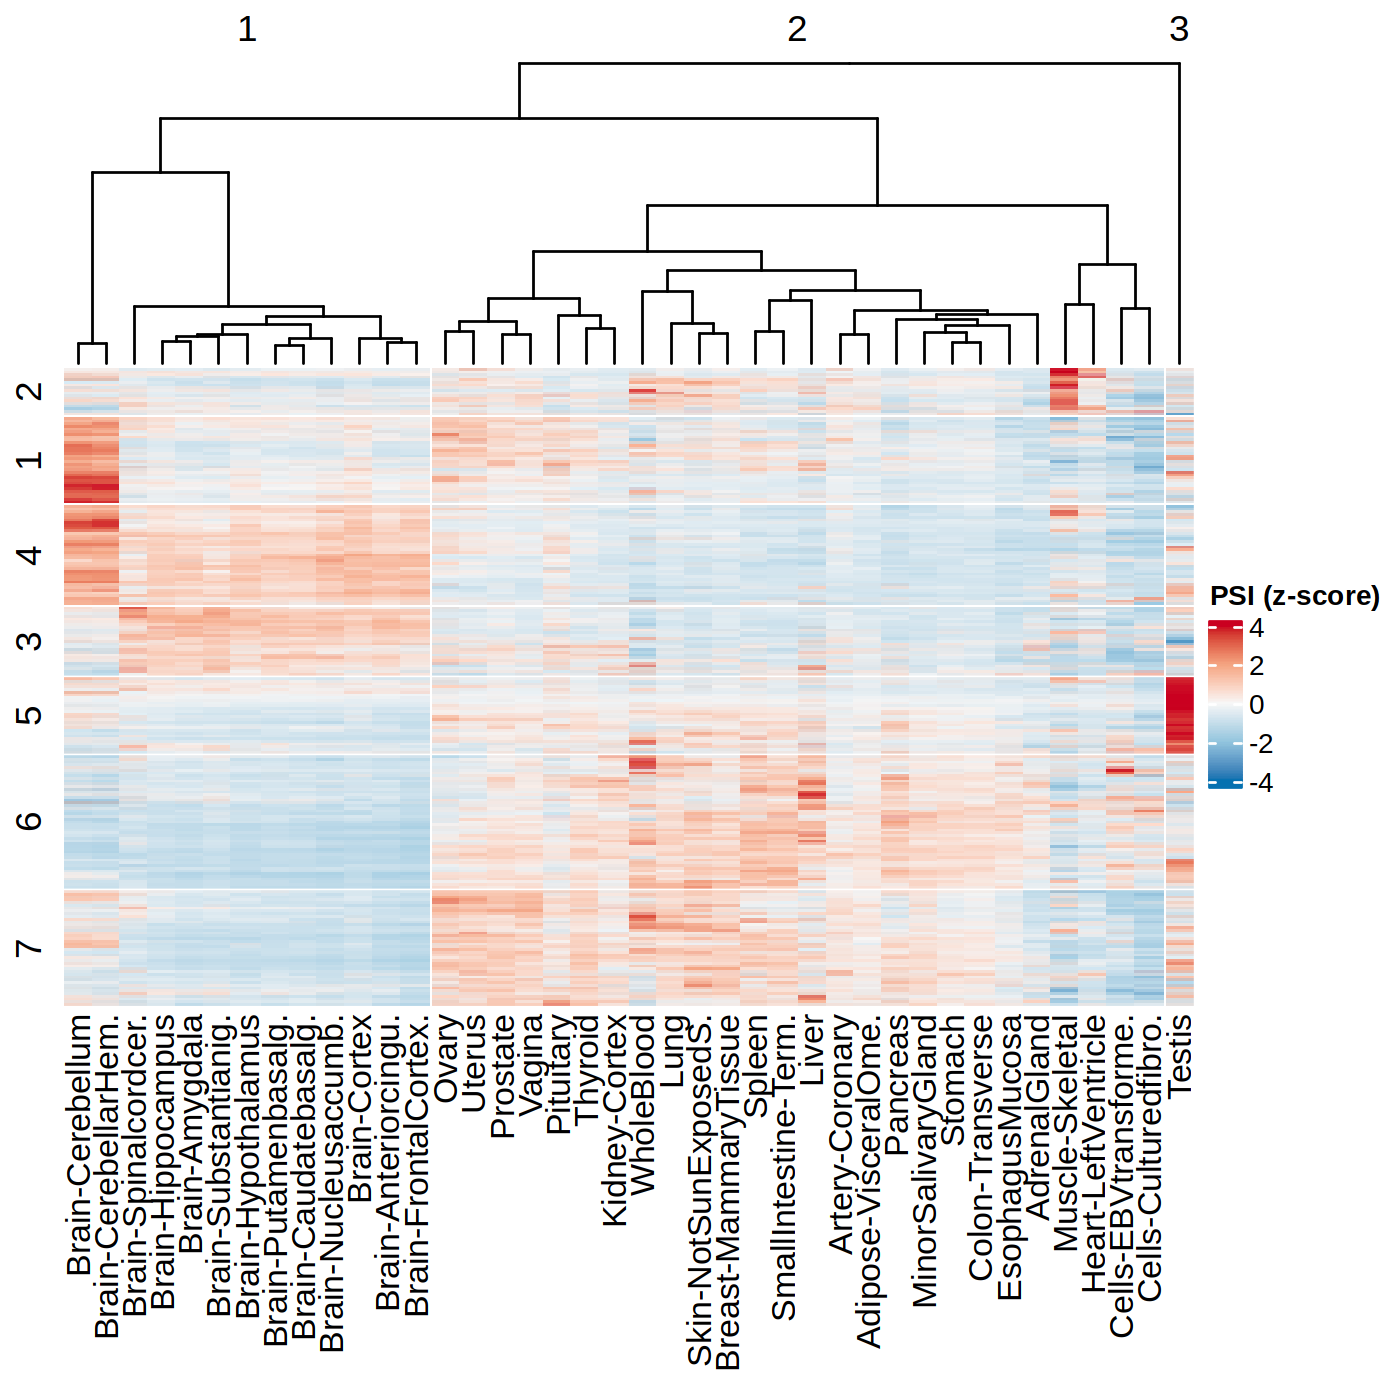

In [ ]:
set.seed(123)
cluster_method <- "ward.D"
legendBreaks <- seq(-4, 4, 2)
mx %>%
  column_to_rownames("intron2") %>%
  as.matrix %>% t %>% scale %>% t %>%
  Heatmap(
    col = circlize::colorRamp2(breaks = legendBreaks, colors = rev(RColorBrewer::brewer.pal(length(legendBreaks), "RdBu"))),
    row_km = 7, row_gap = unit(0.2, "mm"), 
    column_km = 3, column_gap = unit(0.2, "mm"),
    show_parent_dend_line = F,
    show_row_names = FALSE, clustering_method_rows = cluster_method, show_row_dend = T,
    clustering_method_columns = cluster_method, column_dend_height = unit(1.5, "in"), show_column_dend = T,
    column_labels = str_trunc(colLabels, 20, ellipsis = '.'),
    heatmap_legend_param = list(title = "PSI (z-score)"),
    use_raster = T
    )